# Rede neural com camadas escondidas - Classificação do Iris dataset

O objetivo desse experimento é ilustrar o uso de rede neural que tenha mais de uma camada. Isso é conseguido com a inserção de uma ativação não linear entre as camadas.

Datasets utilizados:
    - Iris - 3 classes
    - Sintéticos:
        - meia luas
        - círculos circunscritos
        - blobs

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Net2RegressaoSoftmaxArgmaxRede.png)

## Importando as bibliotecas

In [1]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

## Leitura, normalização e visualização dos dados

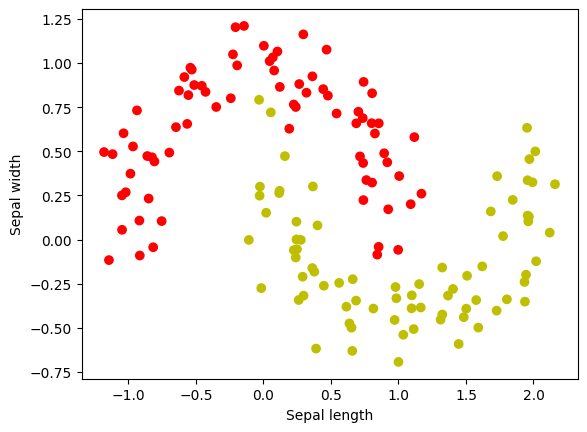

In [2]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option == 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option == 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option == 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option == 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [3]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

## Construindo o modelo da rede

In [4]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=3, bias=True)
  )
)


## _predict_ utilizada para predição de classes e na visualização

In [5]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

## Classe para visualização dinâmica

In [6]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

## Treinamento

In [7]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

### Laço principal de treinamento

Final loss: tensor(0.0052)


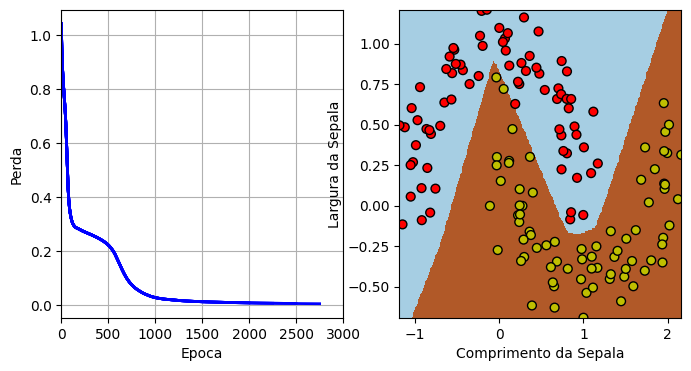

In [8]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

## Avaliação

### Imprimindo pesos finais

In [9]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

dense.0.weight  torch.Size([5, 2])
tensor([[ 3.3754,  1.1090],
        [-1.5721, -0.0321],
        [ 1.0182, -0.8714],
        [-0.9144,  1.4926],
        [ 0.1442, -1.0665]])
dense.0.bias    torch.Size([5])
tensor([-0.7721, -0.0237,  1.7610,  1.6214, -0.1669])
dense.2.weight  torch.Size([5, 5])
tensor([[ 0.0793,  0.3666, -0.5393,  0.3070, -0.2057],
        [-1.5432, -0.0826,  0.9637,  0.4570,  0.5876],
        [ 1.5807,  1.3531, -0.7742,  1.2218, -0.6554],
        [ 2.0490,  0.1017, -0.3582, -1.9286,  0.1892],
        [-2.0011, -0.7573,  1.6817, -0.0937,  0.4949]])
dense.2.bias    torch.Size([5])
tensor([-0.2503,  0.3098,  0.6149, -1.5121,  0.5880])
dense.4.weight  torch.Size([3, 5])
tensor([[ 0.4555, -1.4286,  2.0528, -2.1559, -1.1351],
        [-0.5708,  1.2417, -1.5024,  2.3265,  2.5521],
        [-0.1291,  0.2902, -0.6453, -0.1872, -0.4813]])
dense.4.bias    torch.Size([3])
tensor([ 0.7783,  0.6510, -1.7437])


### Avaliação do classificador

In [10]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  1.0


### Matriz de confusão

In [11]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,75,0
1,0,75


## Atividades

### Experimentos:

1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões.
2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.
3. O que ocorre quando não se utiliza ativação não linear entre camadas?

Final loss: tensor(0.2525)
Training Accuracy:  0.88


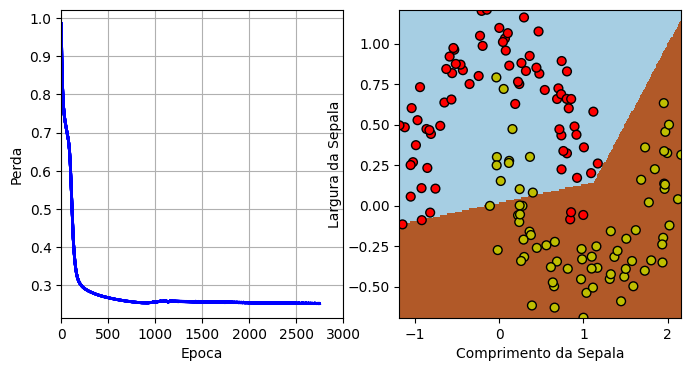

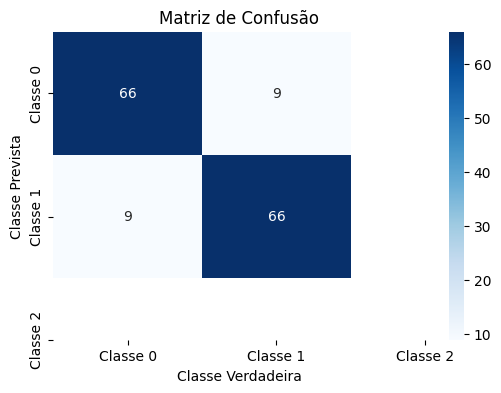

In [19]:
# 1.
import seaborn as sns

# Aumentando a rede
class Modelo_p(nn.Module):
    def __init__(self):
        super(Modelo_p, self).__init__()
        self.dense = nn.Sequential(
            # camada 1 e mais neurônio
            nn.Linear(2, 5),
            nn.ReLU(),
            # camada 2 e mais neurônio
            nn.Linear(5, 4),
            nn.ReLU(),
            # camada 3 e mais neurônio
            nn.Linear(4, 3),
            nn.ReLU(),
            # camada 4 e mais neurônio
            nn.Linear(3, 3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

# Inicializando o modelo
model2 = Modelo_p()
print(model2)

# Hiperparâmetros
lr = 0.15
optimizer = torch.optim.SGD(model2.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
batch_size = 150
nb_epoch = 3000

# Definindo o plotter
boundary_plot_p = BoundaryPlotter(model2, Xc, Y, nb_epoch)

# Treinamento
boundary_plot_p.on_train_begin()
losses_p = []
for i in range(nb_epoch):
    # predict da rede
    output = model2(Variable(X_tensor))
    # Calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_p.append(loss.data)
    boundary_plot_p.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

# Avaliação
Y_hat_p = predict(model2, X_tensor)
accuracy_p = (Y_hat_p == Y).mean()
print('Training Accuracy: ', accuracy_p)

# Matriz de Confusão
cm_p = pd.crosstab(Y_hat_p, Y)
# Exibir matriz de confusão como heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_p, annot=True, cmap="Blues", fmt="d",
            xticklabels=['Classe 0', 'Classe 1', 'Classe 2'],
            yticklabels=['Classe 0', 'Classe 1', 'Classe 2'])
plt.xlabel("Classe Verdadeira")
plt.ylabel("Classe Prevista")
plt.title("Matriz de Confusão")
plt.show()

Mais neurônios: Aumenta a capacidade de aprendizado da rede (mais complexidade).

Mais camadas: Permite aprender padrões mais profundos (deep learning).

Cuidado: Excesso pode causar overfitting (rede aprende demais e não generaliza) e treinamento mais lento.

Final loss: tensor(0.2855)
Training Accuracy:  0.8866666666666667


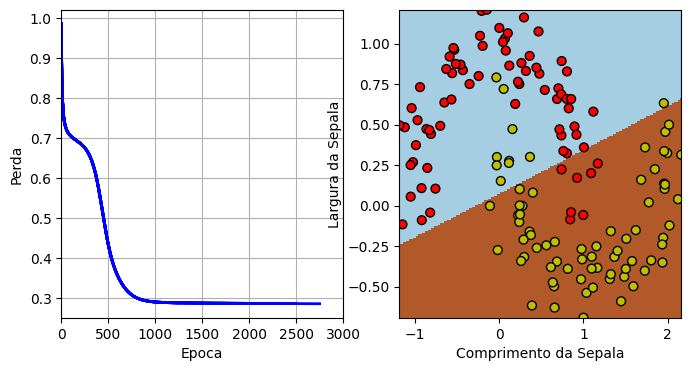

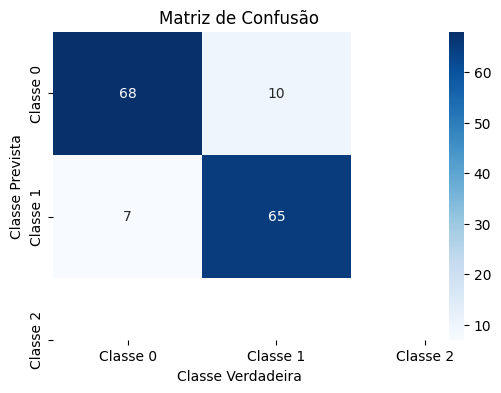

In [20]:
# 2.
class Modelo_p(nn.Module):
    def __init__(self):
        super(Modelo_p, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.Sigmoid(),
            nn.Linear(5, 5),
            nn.Sigmoid(),
            nn.Linear(5,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

# Inicializando o modelo
model2 = Modelo_p()
print(model2)

# Hiperparâmetros
lr = 0.15
optimizer = torch.optim.SGD(model2.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
batch_size = 150
nb_epoch = 3000

# Definindo o plotter
boundary_plot_p = BoundaryPlotter(model2, Xc, Y, nb_epoch)

# Treinamento
boundary_plot_p.on_train_begin()
losses_p = []
for i in range(nb_epoch):
    # predict da rede
    output = model2(Variable(X_tensor))
    # Calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_p.append(loss.data)
    boundary_plot_p.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

# Avaliação
Y_hat_p = predict(model2, X_tensor)
accuracy_p = (Y_hat_p == Y).mean()
print('Training Accuracy: ', accuracy_p)

# Matriz de Confusão
cm_p = pd.crosstab(Y_hat_p, Y)
# Exibir matriz de confusão como heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_p, annot=True, cmap="Blues", fmt="d",
            xticklabels=['Classe 0', 'Classe 1', 'Classe 2'],
            yticklabels=['Classe 0', 'Classe 1', 'Classe 2'])
plt.xlabel("Classe Verdadeira")
plt.ylabel("Classe Prevista")
plt.title("Matriz de Confusão")
plt.show()

No Sigmoid o Training Accuracy e Final loss tiveram valores menores que o ReLu talvez por causa de características fundamentais das funções de ativação e como elas afetam o fluxo de gradientes, aprendizado e representação não-linear.ReLu é melhor adaptada para problemas de classificação não-linear com muitas épocas, Simplicidade computacional, etc.

Final loss: tensor(0.2832)
Training Accuracy:  0.88


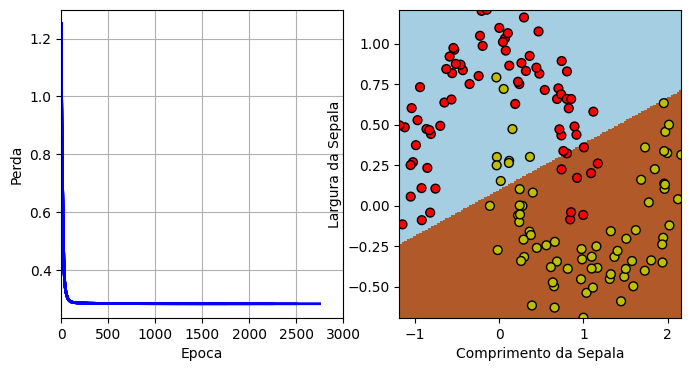

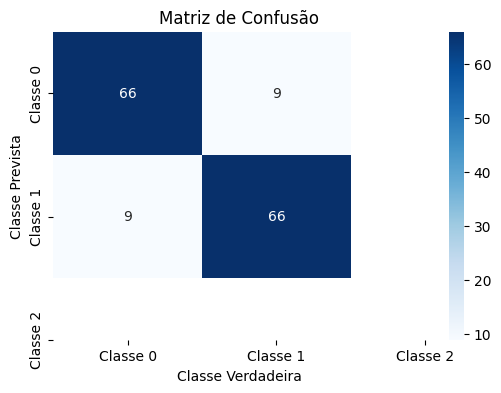

In [21]:
# 3.
class Modelo_na(nn.Module):
    def __init__(self):
        super(Modelo_na, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.Linear(5, 5),
            nn.Linear(5,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

# Inicializando o modelo
model_na = Modelo_na()
print(model_na)

# Hiperparâmetros
lr = 0.15
optimizer = torch.optim.SGD(model_na.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
batch_size = 150
nb_epoch = 3000

# Definindo o plotter
boundary_plot_na = BoundaryPlotter(model_na, Xc, Y, nb_epoch)

# Treinamento
boundary_plot_na.on_train_begin()
losses_na = []
for i in range(nb_epoch):
    # predict da rede
    output = model_na(Variable(X_tensor))
    # Calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_na.append(loss.data)
    boundary_plot_na.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

# Avaliação
Y_hat_na = predict(model_na, X_tensor)
accuracy_na = (Y_hat_na == Y).mean()
print('Training Accuracy: ', accuracy_na)

# Matriz de Confusão
cm_na = pd.crosstab(Y_hat_na, Y)
# Exibir matriz de confusão como heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_na, annot=True, cmap="Blues", fmt="d",
            xticklabels=['Classe 0', 'Classe 1', 'Classe 2'],
            yticklabels=['Classe 0', 'Classe 1', 'Classe 2'])
plt.xlabel("Classe Verdadeira")
plt.ylabel("Classe Prevista")
plt.title("Matriz de Confusão")
plt.show()

O resultado deu parecido com o Sigmoid, pois o Sigmoid tem comportamento quase linear em regiões centrais, ambas(Sigmoid e sem ativação não linear) as redes limitam a capacidade de modelar não linearidades complexas e possivelmente Sigmoid é uma rede linear empilhada.

## Principais aprendizados